In [1]:
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt

### my library

import plots
import utils
import images
import distances
import transforms
import alignments

In [2]:
# PARAMETERS = {metrics: ''}

colors = {'sw_nrf': 'dodgerblue',
          'sw_sgn': 'skyblue',
          'sw_max': 'pink',
          'sc_nrf': 'green',
          'bf': 'salmon',
          'wemd': 'gold',
          'w2': 'blue'}

In [3]:
### inputs

digit = 2
n_imgs = 100
L = 65  # size of image

add_noise = False
snr = 0.001

add_shift = True
s = 6

mask = True
radius = False

In [9]:
### prepare images

np.random.seed(0)

### load original mnist test set data
mnist_image_file = 'Data/t10k-images-idx3-ubyte.gz'
mnist_label_file = 'Data/t10k-labels-idx1-ubyte.gz'

mnist_images = utils.load_mnist_images(mnist_image_file)
mnist_labels = utils.load_mnist_labels(mnist_label_file)

loc = np.argwhere(digit == mnist_labels).flatten()
digit_images = mnist_images[loc]
digit_images = utils.zero_pad_image_stack_to_size(digit_images, L)  # zero pad images to ensure bounded by disk

# ### if using average as reference
# digit_avg = np.mean(digit_images, axis=0)
# ref_images = np.array([digit_avg, digit_avg])
# digit_images = digit_images[:n_imgs]

### if using a single reference
# select a representation of each digit
n_imgs = len(loc) - 1  # use this for all images

ref_digits = {0: 1, 
              1: 5, 
              2: 16, # 16
              3: 32, 
              4: 4, # 761
              5: 833, 
              6: 217, 
              7: 667, 
              8: 3, 
              9: 508}  

ref_idx = ref_digits[digit]
ref_image = digit_images[ref_idx]
digit_images = np.delete(digit_images, ref_idx, axis=0)  # remove reference from image stack
digit_images = digit_images[:n_imgs]

rotations = np.random.randint(0, 360, n_imgs)
# rotations = np.ones(n_imgs) * 180
for idx, img in enumerate(digit_images):
    digit_images[idx] = utils.rotate(img, rotations[idx])
    
if add_shift:
    shifts = np.random.choice((-s, s), (n_imgs, 2))  # generate random shifts in {-s, s}
    # shifts = np.array([[-s, -s] for _ in range(n_imgs)])
    for idx, img in enumerate(digit_images):
        ty, tx = shifts[idx]
        digit_images[idx] = utils.translate(img, ty, tx)
        
### convert to image class and preprocess
refs = images.Image(ref_image, normalize=True, mask=mask, radius=radius, add_noise=add_noise, snr=snr).preprocess_images()
imgs = images.Image(digit_images, normalize=True, mask=mask, radius=radius, add_noise=add_noise, snr=snr).preprocess_images()

In [10]:
imgs.shape, refs.shape

((1031, 65, 65), (1, 65, 65))

In [11]:
### compute distances

N, ny, nx = digit_images.shape

angles = np.linspace(0, 360, ny, endpoint=False)
n_points = ny
n_theta = len(angles)

### *** SLICED WASSERSTEIN DISTANCES *** ###

### sliced Wasserstein (no ramp filter)
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
dists_dict_sw_nrf = distances.reference_rotational_distances(U[0], V)
angles_est_sw_nrf = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_sw_nrf.items()])
print('SW nrf runtime: ', time.time() - t)

### sliced Wasserstein distance (signed)
t = time.time()
Up, Un = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
Vp, Vn = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
dists_dict_sw_sgn = distances.reference_signed_rotational_distances(Up[0], Vp, Un[0], Vn)
angles_est_sw_sgn = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_sw_sgn.items()])
print('SW sgn runtime: ', time.time() - t)

### max sliced Wasserstein distance
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
dists_dict_sw_max = distances.reference_rotational_max_sliced_wasserstein(U[0], V, n_theta, N)
angles_est_sw_max = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_sw_max.items()])
print('SW max runtime: ', time.time() - t)

### *** SLICED CRAMER DISTANCES *** ###
print('\n')

### sliced Cramer distance (no ramp filter)
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform(rescale=True)
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform(rescale=True)
dists_dict_sc_nrf = distances.reference_rotational_distances(U[0], V)
angles_est_sc_nrf = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_sc_nrf.items()])
print('SC nrf runtime: ', time.time() - t)

### *** OTHER DISTANCES *** ###
print('\n')

## Brute force rotations
t = time.time()
dists_dict_bf = {idx: distances.real_space_rotational_distances(refs[0], imgs[idx], angles) for idx in range(n_imgs)}
angles_est_bf = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_bf.items()])
print('    BF runtime: ', time.time() - t)

### Wavelet EMD 
t = time.time()
dists_dict_wemd = {idx: distances.wemd_rotational_distances(refs[0], imgs[idx], angles, wavelet='sym3', level=3) for idx in range(n_imgs)}
angles_est_wemd = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_wemd.items()])
print('  WEMD runtime: ', time.time() - t)

# ### Wasserstein 2
# t = time.time()
# M = distances.compute_transport_matrix(imgs[0], metric='sqeuclidean')
# dists_dict_w2 = {idx: distances.rotational_wasserstein_distance(refs[0], imgs[idx], angles, M) for idx in range(n_imgs)}
# angles_est_w2 = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_w2.items()])
# print('    W2 runtime: ', time.time() - t)

SW nrf runtime:  1.4836366176605225
SW sgn runtime:  2.1227753162384033
SW max runtime:  3.760668992996216


SC nrf runtime:  1.108201265335083


    BF runtime:  30.615506887435913
  WEMD runtime:  47.962692975997925


In [12]:
n_deg_tol = 181

percents_sw_nrf = np.zeros(n_deg_tol)
percents_sw_sgn = np.zeros(n_deg_tol)
percents_sw_max = np.zeros(n_deg_tol)
percents_sc_nrf = np.zeros(n_deg_tol)
percents_bf = np.zeros(n_deg_tol)
percents_wemd = np.zeros(n_deg_tol)
percents_w2 = np.zeros(n_deg_tol)

for n_deg in range(n_deg_tol):
    percents_sw_nrf[n_deg] = plots.within_n_degrees(rotations, angles_est_sw_nrf, n_deg) * 100
    percents_sw_sgn[n_deg] = plots.within_n_degrees(rotations, angles_est_sw_sgn, n_deg) * 100
    percents_sw_max[n_deg] = plots.within_n_degrees(rotations, angles_est_sw_max, n_deg) * 100
    percents_sc_nrf[n_deg] = plots.within_n_degrees(rotations, angles_est_sc_nrf, n_deg) * 100
    percents_bf[n_deg] = plots.within_n_degrees(rotations, angles_est_bf, n_deg) * 100
    percents_wemd[n_deg] = plots.within_n_degrees(rotations, angles_est_wemd, n_deg) * 100
    # percents_w2[n_deg] = plots.within_n_degrees(rotations, angles_est_w2, n_deg) * 100

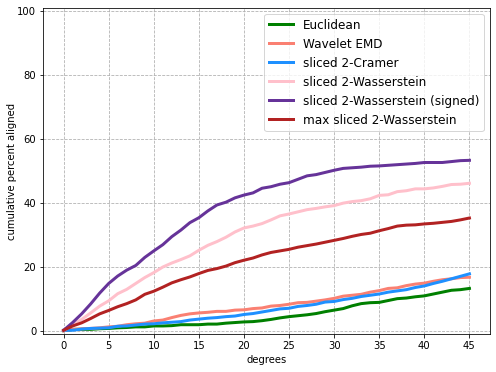

In [13]:
n_deg = 46

plt.figure(figsize=(8,6))

# plt.plot(percents_bf[:n_deg], label='Euclidean', color=colors['bf'], linestyle='-', linewidth=2,   marker='o', markersize=3.5, mec='k', markeredgewidth=0.5)
# plt.plot(percents_wemd[:n_deg], label='Wavelet EMD', color=colors['wemd'], linestyle='-', linewidth=3,  marker='o', markersize=3.5, mec='k', markeredgewidth=0.5)
# plt.plot(percents_sw_nrf[:n_deg], label='sliced 2-Wasserstein', color=colors['sw_nrf'], linestyle='-', linewidth=3 , marker='o', markersize=3.5, mec='k', markeredgewidth=0.5)
# plt.plot(percents_sw_sgn[:n_deg], label='sliced 2-Wasserstein (signed)', color=colors['sw_sgn'], linestyle='-', linewidth=3,  marker='o', markersize=3.5, mec='k', markeredgewidth=0.5) 
# plt.plot(percents_sw_max[:n_deg], label='max sliced 2-Wasserstein', color=colors['sw_max'], linestyle='-', linewidth=3,  marker='o', markersize=3.5, mec='k', markeredgewidth=0.5)
# plt.plot(percents_sc_nrf[:n_deg], label='sliced 2-Cramer', color=colors['sc_nrf'], linestyle='-', linewidth=3,  marker='o', markersize=3.5, mec='k', markeredgewidth=0.5)

colors = {'bf': 'green', 'wemd': 'salmon', 'sw_sgn': 'rebeccapurple', 'sw_max': 'firebrick', 'sc_nrf': 'dodgerblue', 'sw_nrf': 'pink'}


plt.plot(percents_bf[:n_deg], label='Euclidean', color=colors['bf'], linestyle='-', linewidth=3)
plt.plot(percents_wemd[:n_deg], label='Wavelet EMD', color=colors['wemd'], linestyle='-', linewidth=3)
plt.plot(percents_sc_nrf[:n_deg], label='sliced 2-Cramer', color=colors['sc_nrf'], linestyle='-', linewidth=3)
plt.plot(percents_sw_nrf[:n_deg], label='sliced 2-Wasserstein', color=colors['sw_nrf'], linestyle='-', linewidth=3)
plt.plot(percents_sw_sgn[:n_deg], label='sliced 2-Wasserstein (signed)', color=colors['sw_sgn'], linestyle='-', linewidth=3) 
plt.plot(percents_sw_max[:n_deg], label='max sliced 2-Wasserstein', color=colors['sw_max'], linestyle='-', linewidth=3)

# plt.plot(percents_w2[:n_deg], label='2-Wasserstein', color=colors['w2'], linestyle='-', linewidth=3)

plt.ylim(-1, 101)
plt.xlabel('degrees')
plt.ylabel('cumulative percent aligned', labelpad=0)
plt.xticks(np.arange(0, n_deg+1, step=5))
plt.grid(which='major', linestyle='--')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.legend()
# plt.savefig('/home/ev9102/ImageAlignment/FastAlignOT/Output/digit_7_alignment.pdf')
plt.show()

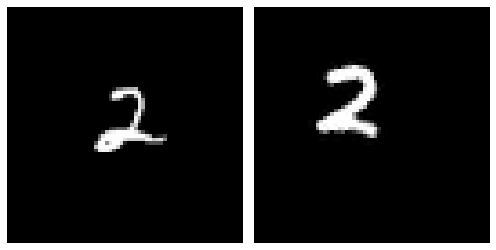

In [15]:
plots.two_imshow(refs[0], imgs[idx], cmap='gray')

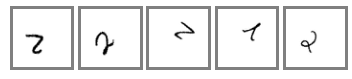

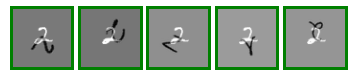

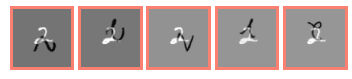

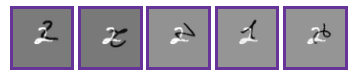

In [16]:
n = 5

plots.line_tile_plot(np.array([imgs[idx] for idx in range(n)]), 
                     n, size=n, spine_colors=['grey' for _ in range(n)], spine_size=3, cmap='gray_r')

plots.line_tile_plot(refs[0] - np.array([utils.rotate(imgs[idx], -angles_est_bf[idx]) for idx in range(n)]), 
                     n, size=n, spine_colors=[colors['bf'] for _ in range(n)], spine_size=3, cmap='gray')

plots.line_tile_plot(refs[0] - np.array([utils.rotate(imgs[idx], -angles_est_wemd[idx]) for idx in range(n)]), 
                     n, size=n, spine_colors=[colors['wemd'] for _ in range(n)],  spine_size=3, cmap='gray')

# plots.line_tile_plot(refs[0] - np.array([utils.rotate(imgs[idx], -angles_est_sw_nrf[idx]) for idx in range(n)]), 
#                      n, size=n, spine_colors=[colors['sw_nrf'] for _ in range(n)],  spine_size=3, cmap='gray')

plots.line_tile_plot(refs[0] - np.array([utils.rotate(imgs[idx], -angles_est_sw_sgn[idx]) for idx in range(n)]), 
                     n, size=n, spine_colors=[colors['sw_sgn'] for _ in range(n)],  spine_size=3, cmap='gray')

# plots.line_tile_plot(refs[0] - np.array([utils.rotate(imgs[idx], -angles_est_sw_max[idx]) for idx in range(n)]), 
#                      n, size=n, spine_colors=[colors['sw_max'] for _ in range(n)], spine_size=3, cmap='gray')

# plots.line_tile_plot(refs[0] - np.array([utils.rotate(imgs[idx], -angles_est_sc_nrf[idx]) for idx in range(n)]), 
#                      n, size=n, spine_colors=[colors['sc_nrf'] for _ in range(n)],  spine_size=3, cmap='gray')

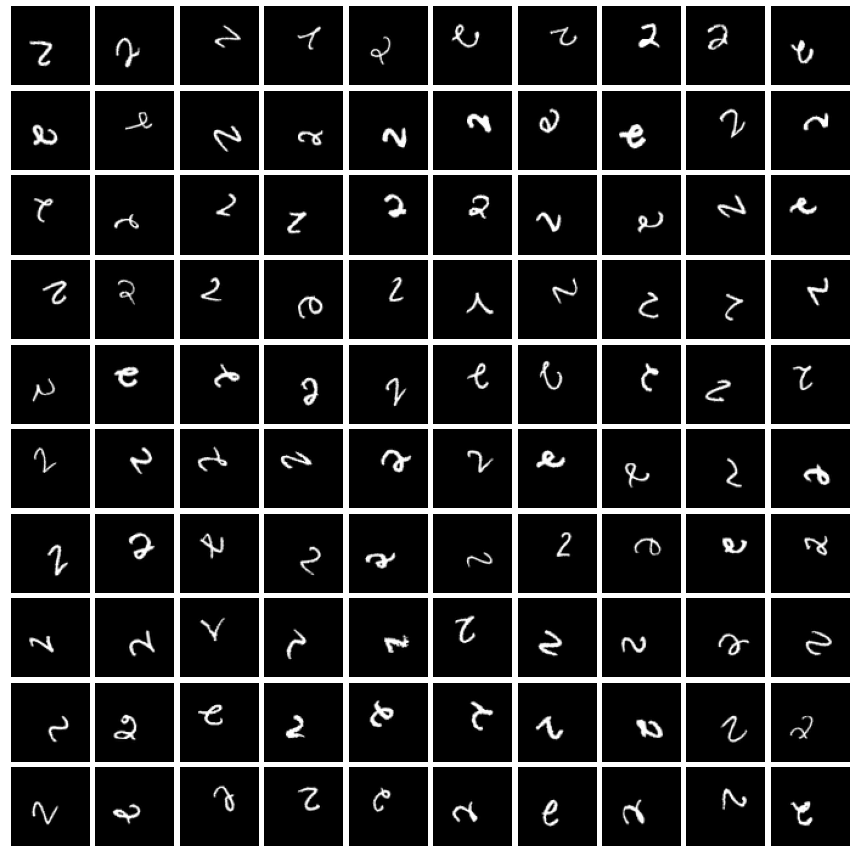

In [17]:
plots.square_tile_plot(imgs, 10, size=12, spine_colors=['k' for _ in range(100)])

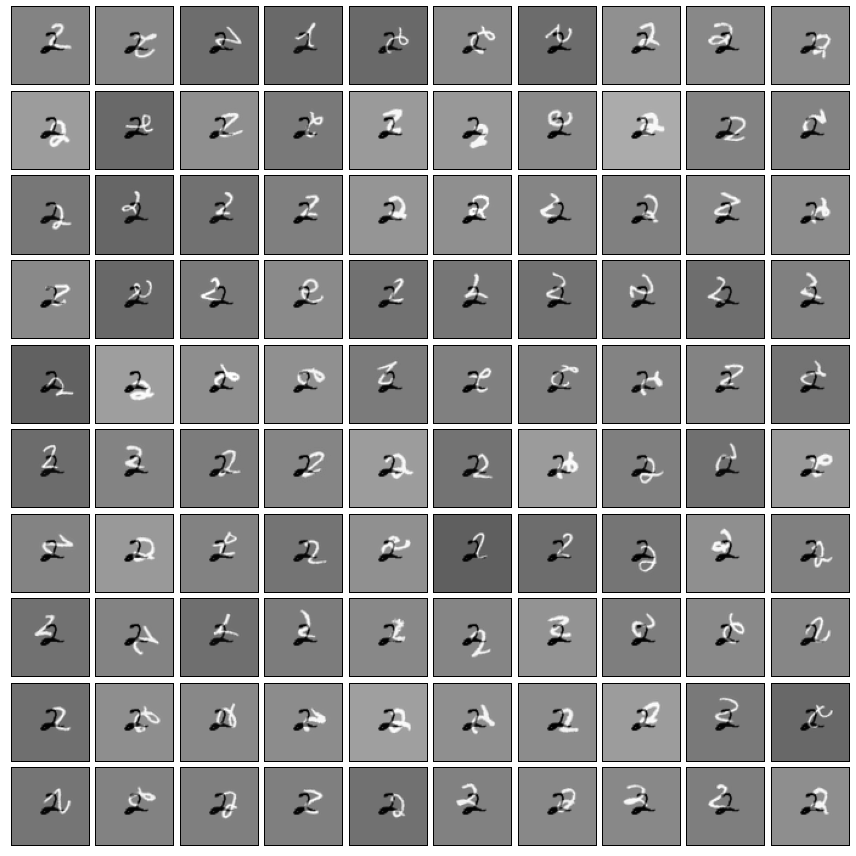

In [18]:
aligned_imgs = np.array([utils.rotate(img, -angles_est_sw_sgn[idx]) for idx, img in enumerate(imgs)])
# aligned_imgs = np.array([utils.rotate(img, -angles_est_bf[idx]) for idx, img in enumerate(imgs)])

plots.square_tile_plot(aligned_imgs - ref_img, 10, size=12, spine_colors=['k' for _ in range(100)])

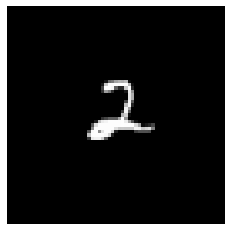

In [19]:
plt.imshow(refs[0], cmap='gray')
plt.axis('off')
plt.show()